<font size=3>This notebook used monte-carlo method to sample the free energies of 12-mer DNA sequences<font>

In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import itertools
import random
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import sys
sys.path.append('../../')

from dim import utils
from dim import dimgen as dim

In [2]:
with open('../../dim/gen_data/dmrf_tetramer_20_4.dmrf', 'rb') as f:
    dmrf = pickle.load(f)

/home/nami/anaconda3/envs/dgm/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/nami/anaconda3/envs/dgm/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<font size=3>Monte-carlo sampling 

In [3]:
list_ = ['CTCTCTCTCTGT','TCCCCTCTCCGT','CCCTCTATTATT', 'GTATTCGTATCT', 'GTTATCCGTATC', 'CGCCGACAAGTC', 'GCCCATGCTTGA','GCGCGGTAACGG','AAGCCGGACGCC','AAAACCTGGCCG']

In [4]:
n_iter = 10000 # sample size
seqences = np.zeros(n_iter).astype(str)
free_en = np.zeros(n_iter).astype(float)

try:
    sample_data = np.genfromtxt('montecarlo_free_energy.dat', dtype=str)
except:
    # Create a list of NA combinations of 12-mer sequences
    seq_list = itertools.product('ATGC', repeat=12)
    seq_list = [''.join(i) for i in seq_list]
     
    with open(file='montecarlo_free_energy.dat', mode='+w') as file:
        for i in range(n_iter):
            if i<10:
                seq = list_[i]
            else:
                seq = random.choice(seq_list)
                
            p = dim.dim(seq=seq, dmrf=dmrf)
            
            seqences[i] = seq
            free_en[i] = p.get_free_energy2().sum()/24
            file.write(f'{seq}\t{free_en[i]:6.3f}\n')
            # print(f'{seq}\t{free_en[i]:6.3f}\n')
            
    sample_data = np.genfromtxt('montecarlo_free_energy.dat', dtype=str)
    
# sort data by accending order
sample_data = sample_data[sample_data[:,1].argsort()]

In [6]:
cut_ = 0.05 # threshold (5%)
data = sample_data[:,1].astype(float)
# Calculate the lower and upper thresholds for the lower and upper 5% tails
lower_threshold = norm.ppf(cut_, loc=np.mean(data), scale=np.std(data))
upper_threshold = norm.ppf(1-cut_, loc=np.mean(data), scale=np.std(data))

lower_ = data[data < lower_threshold]
upper_ = data[data > upper_threshold]

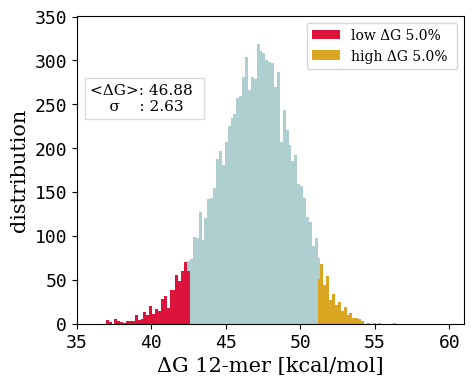

In [7]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(5,4))

bins=np.histogram(np.hstack((lower_,data,upper_)), bins=100)[1]
ax.hist(data, bins=bins, color='cadetblue', alpha=0.5)
ax.hist(lower_, bins, color='crimson', label=f'low ΔG {cut_*100}% ')
ax.hist(upper_, bins, color='goldenrod',label=f'high ΔG {cut_*100}% ')
ax.set_ylim(0,351)
ax.set_yticks(np.arange(0,351,50))
ax.set_yticklabels(np.round(np.arange(0,351,50), decimals=2), fontsize=13, family='monospace')
ax.set_xlim(35,61)
ax.set_xticks(np.arange(35,61,5))
ax.set_xticklabels(np.round(np.arange(35,61,5), decimals=2), fontsize=13, family='monospace')
ax.set_xlabel('ΔG 12-mer [kcal/mol]', fontsize=15)
ax.set_ylabel('distribution', fontsize=15)

textstr = f'<ΔG>: {round(np.mean(data),2)} \n    σ    : {round(np.std(data),2)}'
ax.text(0.035, 0.78, textstr, transform=ax.transAxes, fontsize=11, 
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.15, edgecolor='black'))

plt.legend()
plt.show()

<font size=3>Pick the highest and lowest from the distribution and randomly select 4 more sequences from both edges of the distribution considering the 5% cutoff.

In [11]:
s = []
s.append(sample_data[0])
s.append(sample_data[-1])

for i in range(4):
    s.append(random.choice(sample_data[:lower_.shape[0]]))
    s.append(random.choice(sample_data[-upper_.shape[0]:]))

s = np.array(s)

s = s[s[:,1].argsort()]

for i in s:
    print(i[0], ' : ', round(float(i[1])/24,1))

AGCGAATAGATA  :  1.5
ATAGACCAGATG  :  1.7
GGGTAGAGTAAA  :  1.7
CTCGGAAGATAC  :  1.7
GGAAGGGTATGT  :  1.8
CTTTGGGTTTTT  :  2.1
GGCTTTTCAGGC  :  2.1
CCGCGACTCGAG  :  2.1
CTGGGCCAAGCA  :  2.2
GCCGGCGCGCGC  :  2.4


<font size=3>Investigate the edges for their base composition

In [12]:
def percent_composition(seq_array):
    A=T=G=C=0
    tot = seq_array.shape[0]*len(seq_array[0])/50
    for seq in seq_array:
        seq = seq+utils.complementary(seq)
        A += seq.count('A')
        T += seq.count('T')
        G += seq.count('G')
        C += seq.count('C')
    return {'A':A/tot, 'T':T/tot, 'G':G/tot, 'C':C/tot}

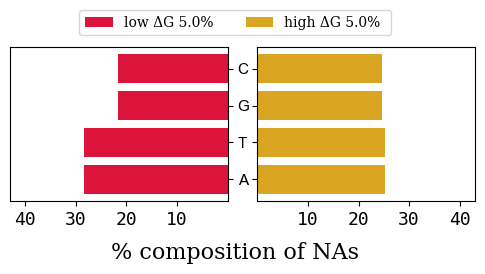

In [ ]:
cut_ = 0.05 
data = sample_data[:,1].astype(float)
# Calculate the lower and upper thresholds for the lower and upper 5% tails
lower_threshold = norm.ppf(cut_, loc=np.mean(data), scale=np.std(data))
upper_threshold = norm.ppf(1-cut_, loc=np.mean(data), scale=np.std(data))

lower_seq = sample_data[np.where(data<lower_threshold)[0],0]
upper_seq = sample_data[np.where(data<upper_threshold)[0],0]

low_ = list(percent_composition(lower_seq).values())
up_ = list(percent_composition(upper_seq).values())
categories = list(percent_composition(lower_seq).keys())

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(6,2))

ax1.barh(categories,-np.array(low_), color='crimson', label=f'low ΔG {cut_*100}% ')
ax2.barh(categories,np.array(up_), color='goldenrod', label=f'high ΔG {cut_*100}% ')

ax1.set_xlim(-43,0)
ax2.set_xlim(0,43)

ax1.set_xticks(range(-40,-9,10))
ax1.set_xticklabels([str(abs(int(x))) for x in ax1.get_xticks()], fontsize=13, family='monospace')
ax1.set_yticks(range(4))
ax1.set_yticklabels(categories, fontsize=11, family='Arial')
ax2.set_xticks(range(10,41,10))
ax2.set_xticklabels(range(10,41,10), fontsize=13, family='monospace')

ax1.yaxis.tick_right()
plt.subplots_adjust(wspace=0.135)

fig.text(0.5, -0.18, '% composition of NAs', ha='center', fontsize=16)
fig.legend(loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=[0.5, 1.1])
plt.show()

<font size=3>Plot the base composition Vs. the free energy change (curve fit with 2nd degree polynomial)</font>

In [14]:
A,T,G,C = {},{},{},{}
free_ = []
for i in range(100):
    up = bins[i+1]
    down = bins[i]
    seqs = sample_data[np.where((data <= up) & (data > down))][:,0]
    
    if seqs.shape[0]!=0:
        composition = percent_composition(seqs)
        A[i] = composition['A']
        T[i] = composition['T']
        G[i] = composition['G']
        C[i] = composition['C']
        
        free_.append((up+down)/2.0)   

In [15]:
def fit_(X, y, num=1000):
    coefficients = np.polyfit(X, y, 2)
    print(coefficients) # a(x^2)+b(x)+c : [a,b,c]
    poly = np.poly1d(coefficients)
    X_range = np.linspace(X.min(), X.max(), num)
    r2 = r2_score(y, poly(X))
    return [X_range, poly(X_range), round(r2, 3)]
    

[-7.33815242e-02  5.73517564e+00 -8.21807002e+01]
[-7.33815242e-02  5.73517564e+00 -8.21807002e+01]
[ 7.33815242e-02 -5.73517564e+00  1.32180700e+02]
[ 7.33815242e-02 -5.73517564e+00  1.32180700e+02]


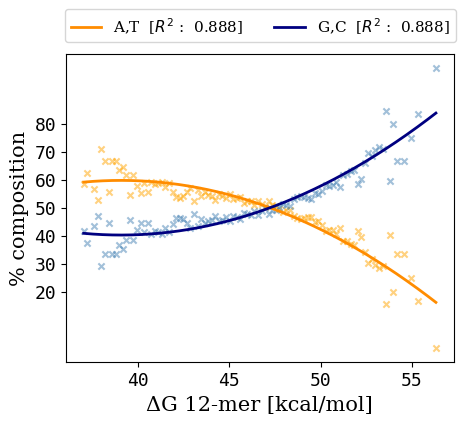

In [16]:
fig, ax3 = plt.subplots(figsize=(5,4))

ax3.scatter(free_, np.array(list(A.values()))*2, s=20,marker='x', color='orange', alpha=0.5)
# ax3.scatter(free_, T.values(), s=15,marker='x', color='tomato', alpha=0.5)
ax3.scatter(free_, np.array(list(G.values()))*2, s=20,marker='x', color='steelblue', alpha=0.5)
# ax3.scatter(free_, C.values(), s=15,marker='x', color='green', alpha=0.5)

pred_A = fit_(np.array(free_), list(A.values()))
pred_T = fit_(np.array(free_), list(T.values()))
pred_G = fit_(np.array(free_), list(G.values()))
pred_C = fit_(np.array(free_), list(C.values()))

ax3.plot(pred_A[0], pred_A[1]*2, linewidth=2, color='darkorange', label=f'A,T  [$R^2$ :  {pred_A[2]}]')
# ax3.plot(pred_T[0], pred_T[1], linewidth=2, color='red', label=f'T  [$R^2$ :  {pred_T[2]}]')
ax3.plot(pred_G[0], pred_G[1]*2, linewidth=2, color='navy', label=f'G,C  [$R^2$ :  {pred_G[2]}]')
# ax3.plot(pred_C[0], pred_C[1], linewidth=2, color='green', label=f'C  [$R^2$ :  {pred_C[2]}]')

fig.legend(fontsize=11, bbox_to_anchor=[0.92, 1.01], ncols=2)

ax3.set_xticks(range(40,60,5))
ax3.set_xticklabels(range(40,60,5), fontsize=13, family='monospace')
ax3.set_yticks(range(20,85,10))
ax3.set_yticklabels(range(20,85,10), fontsize=13, family='monospace')

ax3.set_xlabel('ΔG 12-mer [kcal/mol]', fontsize=15)
ax3.set_ylabel('% composition', fontsize=15)

plt.show()